In [2]:
import numpy as np
import pandas as pd
import nibabel as nib 
import glob
import tensorflow as tf
import matplotlib.pyplot as plt 
from tifffile import imsave 
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.utils import to_categorical
import os 
import random
from custom_generator import imageLoader, load_images
from Unet_3D import Unet_3D_multiclass
import segmentation_models_3D as sm
from tensorflow.keras.models import load_model
from Processing_tools import filter_based_on_masks

# Handling the Dataset


### Dealing with one training Example

In [9]:
TRAIN_DATASET_PATH = "BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
test_subject  = list() # for the different modalities  
for file in os.listdir(TRAIN_DATASET_PATH + '/BraTS20_Training_001'): 
    file_path = os.path.join(TRAIN_DATASET_PATH + '/BraTS20_Training_001', file) 
    curr_image = nib.load(file_path) 
    test_subject.append((file, curr_image.get_fdata())) 

In [10]:
modalities_order = list()
for modality, image in test_subject[::-1]:
    print(f'modality type: {modality}, image_shape {image.shape}, max value (scale check): {(image.min(),image.max())}')
    modalities_order.append(modality)

modality type: BraTS20_Training_001_t2.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 376.0)
modality type: BraTS20_Training_001_t1ce.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 1845.0)
modality type: BraTS20_Training_001_t1.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 678.0)
modality type: BraTS20_Training_001_seg.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 4.0)
modality type: BraTS20_Training_001_flair.nii, image_shape (240, 240, 155), max value (scale check): (0.0, 625.0)


In [11]:
scalar = MinMaxScaler() # to overcome the scalar variance
rescaled_subject_test = list()
for modality,image in test_subject[::-1]:   
    if modality != "BraTS20_Training_001_seg.nii": # avoid adjusting the mask 
        rescaled_image = scalar.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape) # fit_transform doesn't work on 3D 
        rescaled_subject_test.append(rescaled_image)
    else:
        mask_image = image.astype(np.uint8) # save some memory 
        rescaled_subject_test.append(mask_image) # just the mask

In [12]:
for image in rescaled_subject_test:
    print(f'max value (scale check): {(image.min(),image.max())}') 
# ready to preceed :) 

max value (scale check): (0.0, 1.0)
max value (scale check): (0.0, 1.0)
max value (scale check): (0.0, 1.0)
max value (scale check): (0, 4)
max value (scale check): (0.0, 1.0)


In [13]:
# the mask values 
print(f"The labels we have: {np.unique(rescaled_subject_test[3].reshape(-1, 1))}") 
val, counts = np.unique(rescaled_subject_test[3].reshape(-1, 1), return_counts=True)
print(val, counts) # this can be used later on the reject useless data (useless in this context mean has less important data)

The labels we have: [0 1 2 4]
[0 1 2 4] [8716021   15443  168794   27742]


It seems that there are some missed labels, especifically label **3**, so reassign each 4-valued label to 3

In [14]:
rescaled_subject_test[3][rescaled_subject_test[3] == 4] = 3 

In [15]:
modalities_order

['BraTS20_Training_001_t2.nii',
 'BraTS20_Training_001_t1ce.nii',
 'BraTS20_Training_001_t1.nii',
 'BraTS20_Training_001_seg.nii',
 'BraTS20_Training_001_flair.nii']

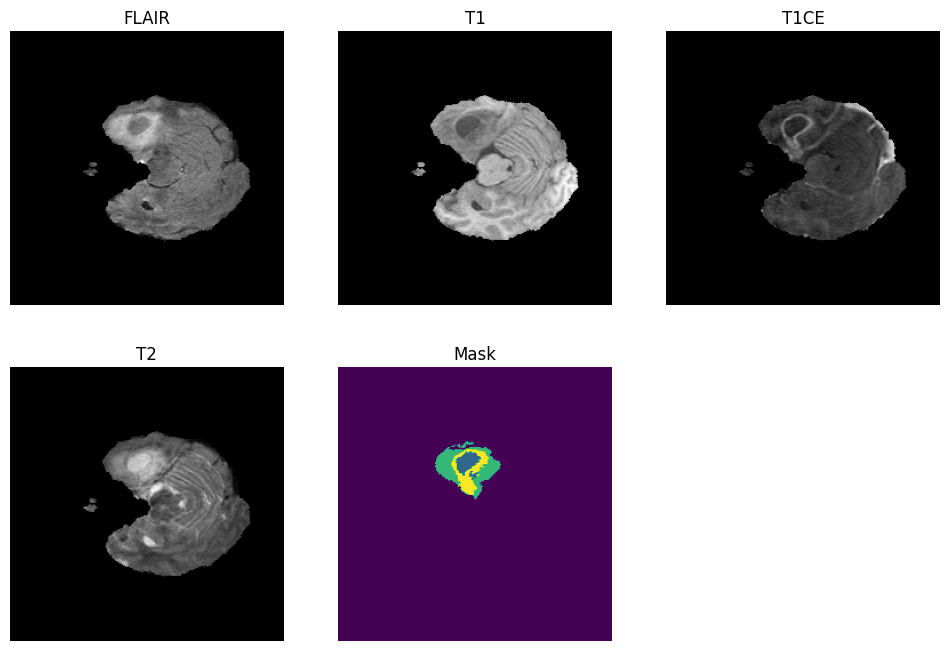

In [24]:
selected_slice = random.randint(0, rescaled_subject_test[0].shape[-1])

plt.figure(figsize=(12,8))

plt.subplot(231) 
plt.imshow(rescaled_subject_test[4][:,:,selected_slice], cmap="gray")
plt.title("FLAIR")
plt.axis("off")
plt.subplot(232) 
plt.imshow(rescaled_subject_test[2][:,:,selected_slice], cmap="gray")
plt.title("T1")
plt.axis("off")
plt.subplot(233) 
plt.imshow(rescaled_subject_test[1][:,:,selected_slice], cmap="gray")
plt.title("T1CE")
plt.axis("off")
plt.subplot(234) 
plt.imshow(rescaled_subject_test[0][:,:,selected_slice], cmap="gray")
plt.title("T2")
plt.axis("off")
plt.subplot(235) 
plt.imshow(rescaled_subject_test[3][:,:,selected_slice])
plt.title("Mask")
plt.axis("off");

Worth noting that most of volumes are useless in the sense that they just add on a redundant computational cost, we need to handle this problem later on to save us wasting resources.  

In [25]:
# stacking all these volumns together to use it later one in the training process 
combined_subject_data = np.stack([rescaled_subject_test[4], rescaled_subject_test[2], rescaled_subject_test[1], rescaled_subject_test[0]], axis= 3) 
print(f'The size before cropping: {combined_subject_data.shape}') 
# in order to get rid of the redundant data exists we need to crop the volume and make it of order of 2 to accelerate the computation 
print(f"[{(240 - 128)//2}, {(240 - 128)//2}, {(155 - 128)//2}]") 
cropped_subject_data = combined_subject_data[56:(240-56),56:(240-56),13:(155-14)]  # depth is of odd size 
print(f'The size before cropping: {cropped_subject_data.shape}')

The size before cropping: (240, 240, 155, 4)
[56, 56, 13]
The size before cropping: (128, 128, 128, 4)


In [26]:
# same is done for the mask 
subject_mask = rescaled_subject_test[3][56:(240-56),56:(240-56),13:(155-14)]
print(f"the mask size: {subject_mask.shape}") 

the mask size: (128, 128, 128)


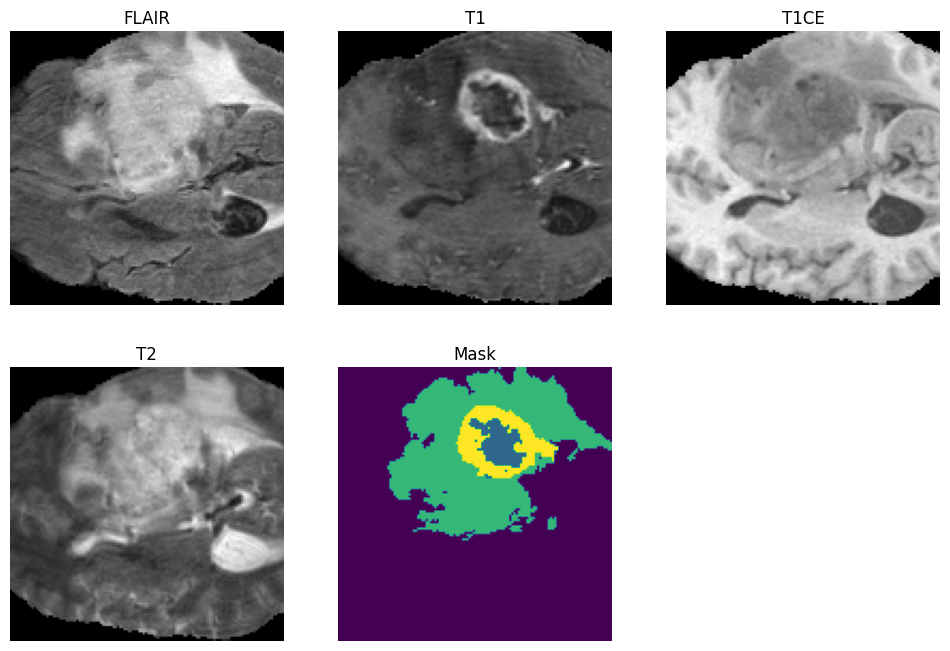

In [29]:
selected_slice = random.randint(0, 128)

plt.figure(figsize=(12,8))
plt.subplot(231) 
plt.imshow(cropped_subject_data[:,:,selected_slice,0], cmap="gray")
plt.title("FLAIR")
plt.axis("off")
plt.subplot(232) 
plt.imshow(cropped_subject_data[:,:,selected_slice,2], cmap="gray")
plt.title("T1")
plt.axis("off")
plt.subplot(233) 
plt.imshow(cropped_subject_data[:,:,selected_slice,1], cmap="gray")
plt.title("T1CE")
plt.axis("off")
plt.subplot(234) 
plt.imshow(cropped_subject_data[:,:,selected_slice,3], cmap="gray")
plt.title("T2")
plt.axis("off")
plt.subplot(235) 
plt.imshow(subject_mask[:,:,selected_slice])
plt.title("Mask")
plt.axis("off");

slight loss, but would save a lot!!!!


In [13]:
# one-hot encoding of the mask 
subject_encoded_mask = to_categorical(subject_mask, num_classes=4)
subject_encoded_mask.shape

(128, 128, 128, 4)

### Training & Validation Splitting

In [14]:
# listing all the volumes of all subjects 
t1_list_train_val = sorted(glob.glob("BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii"))
t1ce_list_train_val = sorted(glob.glob("BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii"))
t2_list_train_val = sorted(glob.glob("BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii"))
flair_list_train_val = sorted(glob.glob("BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii"))
mask_list_train_val = sorted(glob.glob("BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii"))
print(mask_list_train_val[0]) # list of file names 
print(f"the number of masks: {len(mask_list_train_val)}") # list of file names 
print(f"the number of volumes: {len(t1_list_train_val)}")

/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii
the number of masks: 368
the number of volumes: 369


It seems that there is a missing segmentation mask due to misnaming

In [15]:
print(mask_list_train_val[353])
print(mask_list_train_val[354])

/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_354/BraTS20_Training_354_seg.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_356/BraTS20_Training_356_seg.nii


In [16]:
misnamed_subject = "BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
mask_list_train_val.insert (354, misnamed_subject)

In [17]:
print(mask_list_train_val[354])

/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii


In [19]:
subjects_list = sorted(glob.glob("BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20*"))
print(len(subjects_list))

369


In [20]:
filtered_subjects_list  = filter_based_on_masks(subjects_list)

In [21]:
indices = list(range(len(filtered_subjects_list)))

random.seed(42)  # For reproducibility
random.shuffle(indices)

train_ratio = 0.75
split_index = int(train_ratio * len(filtered_subjects_list))

train_indices = indices[:split_index]
val_indices = indices[split_index:]

train_subjects = [filtered_subjects_list [i] for i in train_indices]
val_subjects = [filtered_subjects_list [i] for i in val_indices]

print("Training files:", len(train_subjects))
print("Validation files:", len(val_subjects))
print(train_subjects[:2])

Training files: 258
Validation files: 86
['/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_303', '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_195']


### Testing Data 

In [22]:
t1_list_test = sorted(glob.glob("BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/*/*t1.nii"))
t1ce_list_test = sorted(glob.glob("BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/*/*t1ce.nii"))
t2_list_test = sorted(glob.glob("BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/*/*t2.nii"))
flair_list_test = sorted(glob.glob("BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/*/*flair.nii"))
print(len(t1_list_test))

125


### Custom Data Generator

In [25]:
BATCH_SIZE = 8
train_data_generator = imageLoader(train_subjects, BATCH_SIZE)
val_data_generator = imageLoader(val_subjects, BATCH_SIZE)

train_epoch_steps = len(train_subjects) // BATCH_SIZE
val_epoch_steps = len(val_subjects) // BATCH_SIZE


print(f"Number of steps in each training epoch: {train_epoch_steps}")
print(f"Number of steps in each validation epoch: {val_epoch_steps}")

Number of steps in each training epoch: 32
Number of steps in each validation epoch: 10


<Figure size 1200x800 with 0 Axes>

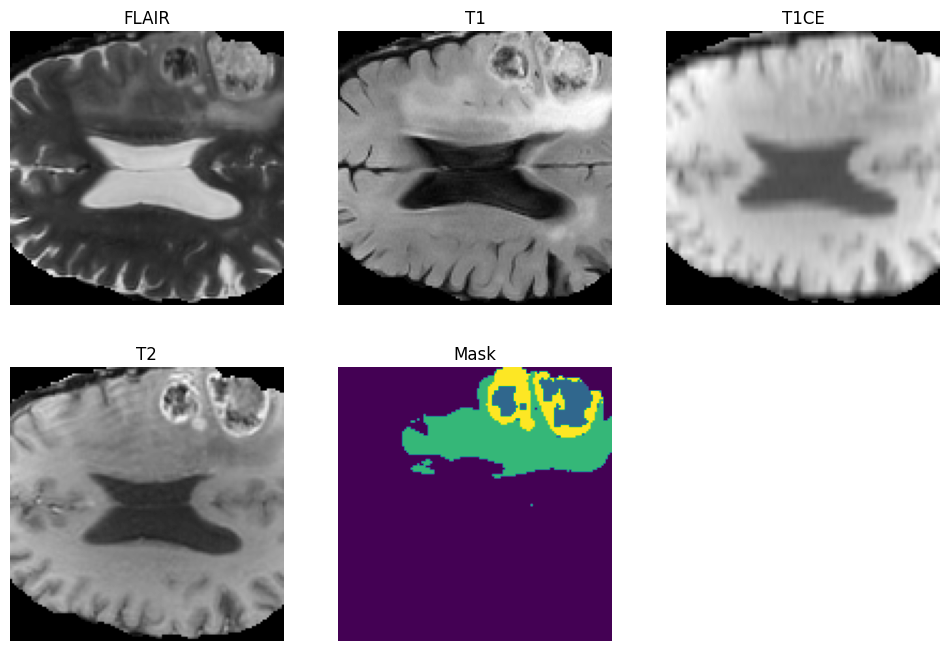

In [26]:
img, msk = train_data_generator.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask= np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.figure(figsize=(12,8))
plt.subplot(231) 
plt.imshow(test_img[:,:,n_slice,0], cmap="gray")
plt.title("FLAIR")
plt.axis("off")
plt.subplot(232) 
plt.imshow(test_img[:,:,n_slice,2], cmap="gray")
plt.title("T1")
plt.axis("off")
plt.subplot(233) 
plt.imshow(test_img[:,:,n_slice,1], cmap="gray")
plt.title("T1CE")
plt.axis("off")
plt.subplot(234) 
plt.imshow(test_img[:,:,n_slice,3], cmap="gray")
plt.title("T2")
plt.axis("off")
plt.subplot(235) 
plt.imshow(test_mask[:,:,n_slice])
plt.title("Mask")
plt.axis("off");

# Defining the Model 

In [28]:
IMG_WIDTH, IMG_HEIHGT, IMG_DEPTH, IMG_CHANNEL = (128,128,128,4)
model = Unet_3D_multiclass(IMG_WIDTH, IMG_HEIHGT, IMG_DEPTH, IMG_CHANNEL, num_classes=4)
model.summary()
print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,744 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,646,260 (21.54 MB)

 Trainable params: 5,646,260 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 4)
(None, 128, 128, 128, 4)


We need to find the distribution of each label in the masks to get weights to substitute for the imbalance of labels.


### Define Weights for Labels to Compensate for the Imbalance  

In [29]:
train_mask_list = list()
for sub in train_subjects:
    for filename in os.listdir(sub): 
        if "seg" in filename or "Seg" in filename: # due to the misnaming
            whole_path = os.path.join(sub, filename)
            train_mask_list.append(whole_path)
print(len(train_mask_list))

258


In [30]:
labels = [0, 1, 2, 3]
df = pd.DataFrame(columns=labels)

In [31]:
for sub in range(len(train_mask_list)):
    curr_mask = nib.load(train_mask_list[sub]).get_fdata().astype(np.uint8)
    curr_mask[curr_mask == 4] = 3
    vals, counts = np.unique(curr_mask, return_counts=True)
    zipped = zip(vals, counts)
    count_dict = dict(zipped)
    temp_df = pd.DataFrame([count_dict])

    df = pd.concat([df, temp_df], ignore_index=True)

df.head()

,0,1,2,3
0,8892149,23874,10653,1324
1,8877265,11141,18410,21184
2,8810063,8884,90387,18666
3,8836354,10482,74456,6708
4,8788743,45839,73741,19677


In [32]:
label_0 = df[0].sum() 
label_1 = df[1].sum()
label_2 = df[2].sum()
label_3 = df[3].sum()
total_count = label_0 + label_1 + label_2 + label_3
num_classes = 4 

# weight for each class during training 
w_0 = round(total_count / (label_0 * num_classes), 2)
w_1 = round(total_count / (label_1 * num_classes), 2)
w_2 = round(total_count / (label_2 * num_classes), 2)
w_3 = round(total_count / (label_3 * num_classes), 2)
print(f"W_0: {w_0}, W_1: {w_1}, W_2: {w_2}, W_3: {w_3}")

W_0: 0.25, W_1: 96.73, W_2: 37.15, W_3: 112.41


### Training and Validation 

In [33]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([w_0,w_1,w_2,w_3])) # correct for the imbalance in dataset
focal_loss = sm.losses.CategoricalFocalLoss() # don't pay too much attention to high estimated voxels 
total_loss = dice_loss + focal_loss

metrices = ["accuracy", sm.metrics.IOUScore(threshold=0.5)]
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optim, loss= total_loss, metrics = metrices)

In [34]:
history = model.fit(train_data_generator, steps_per_epoch=train_epoch_steps, epochs=50, validation_data = val_data_generator, validation_steps=val_epoch_steps)
model.save("BraTS2020_50_Epochs.h5") 

Epoch 1/50


I0000 00:00:1725659087.316169      77 service.cc:145] XLA service 0x7ef248009d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725659087.316248      77 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-09-06 21:45:01.076684: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[8,16,128,128,128]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,16,128,128,128]{4,3,2,1,0}, f32[16,16,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-06 21:45:03.114114: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.0

31/32 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.0944 - iou_score: 0.0157 - loss: -0.3920

2024-09-06 21:52:24.046591: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[2,16,128,128,128]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,128,128,128]{4,3,2,1,0}, f32[16,32,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-06 21:52:24.561065: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.514584829s
Trying algorithm eng0{} for conv (f32[2,16,128,128,128]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,128,128,128]{4,3,2,1,0}, f32[16,32,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward

32/32 ━━━━━━━━━━━━━━━━━━━━ 632s 17s/step - accuracy: 0.0944 - iou_score: 0.0160 - loss: -0.3983 - val_accuracy: 0.2558 - val_iou_score: 0.0264 - val_loss: -0.7003
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2236 - iou_score: 0.0325 - loss: -0.5513 

2024-09-06 22:01:17.065251: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[6,16,128,128,128]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[6,16,128,128,128]{4,3,2,1,0}, f32[16,16,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-06 22:01:18.343192: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.278036869s
Trying algorithm eng0{} for conv (f32[6,16,128,128,128]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[6,16,128,128,128]{4,3,2,1,0}, f32[16,16,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward

32/32 ━━━━━━━━━━━━━━━━━━━━ 489s 16s/step - accuracy: 0.2265 - iou_score: 0.0336 - loss: -0.5618 - val_accuracy: 0.6409 - val_iou_score: 0.1769 - val_loss: -1.4547
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 484s 16s/step - accuracy: 0.7778 - iou_score: 0.2073 - loss: -0.8073 - val_accuracy: 0.8134 - val_iou_score: 0.2102 - val_loss: 0.6732
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 417s 13s/step - accuracy: 0.8338 - iou_score: 0.2139 - loss: 0.7208 - val_accuracy: 0.8445 - val_iou_score: 0.2179 - val_loss: 0.6393
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 378s 12s/step - accuracy: 0.8639 - iou_score: 0.2220 - loss: 0.5523 - val_accuracy: 0.8034 - val_iou_score: 0.2111 - val_loss: -0.0984
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 384s 12s/step - accuracy: 0.8008 - iou_score: 0.2095 - loss: 0.0198 - val_accuracy: 0.7599 - val_iou_score: 0.2011 - val_loss: -0.1312
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 392s 13s/step - accuracy: 0.7692 - iou_score: 0.2019 - loss: 0.0571 - val_accuracy: 0.7639 - val_iou_score: 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'IoU Score')]

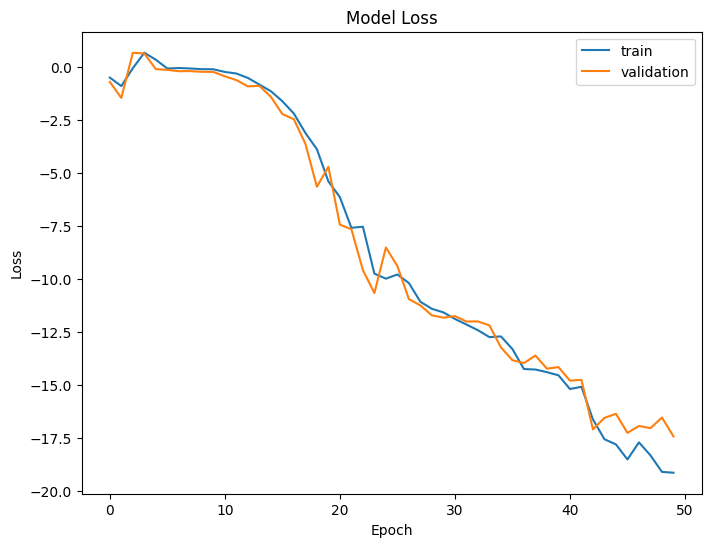

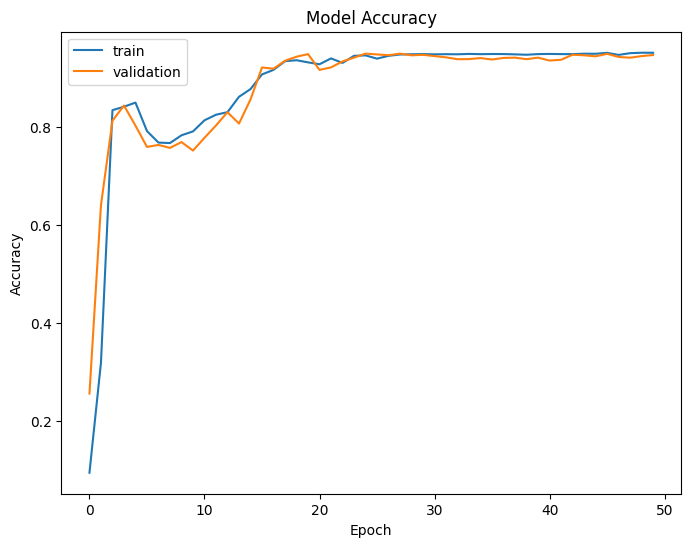

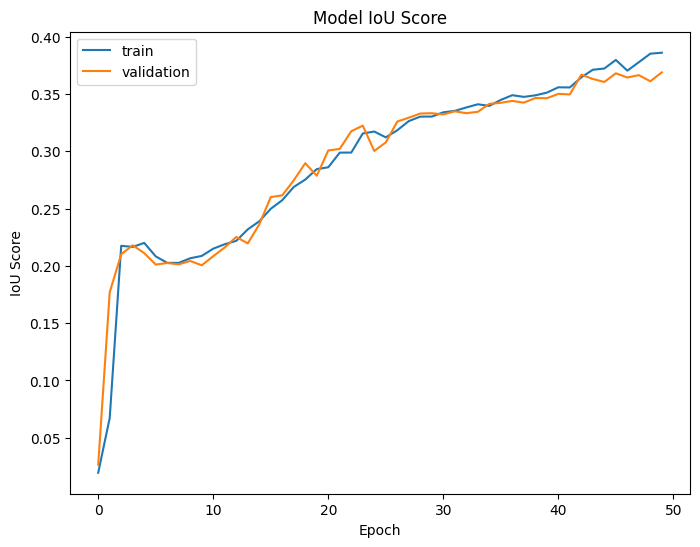

In [35]:
df_loss_acc = pd.DataFrame(history.history)

# Plot Loss
df_loss = df_loss_acc[['loss', 'val_loss']].copy()
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)
df_loss.plot(title='Model Loss', figsize=(8, 6)).set(xlabel='Epoch', ylabel='Loss')

# Plot Accuracy
df_acc = df_loss_acc[['accuracy', 'val_accuracy']].copy()
df_acc.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)
df_acc.plot(title='Model Accuracy', figsize=(8, 6)).set(xlabel='Epoch', ylabel='Accuracy')

# Plot IoU Score
df_iou = df_loss_acc[['iou_score', 'val_iou_score']].copy()
df_iou.rename(columns={'iou_score': 'train', 'val_iou_score': 'validation'}, inplace=True)
df_iou.plot(title='Model IoU Score', figsize=(8, 6)).set(xlabel='Epoch', ylabel='IoU Score')
